In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
import os

sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

from train import *  


%load_ext autoreload
%autoreload 2

os.getcwd()

'/Users/gguichaoua/Dropbox/gwenn/these/2025_04_29 these/github/17-MT-rel-genes/tests'

In this notebook, we study the RO4 dataset (GSE63471), which contains microarray expression data of breast cancer tumors that were subjected to taxane-based neoadjuvant chemotherapies. Some patients in the cohort achieved pCR and other not.

On the other hand, we dispose of a list of microtubule-related genes (and their corresponding probes), which we think play a role in the acquisition of chemoresistance. However, this mechanism of chemoresistance may not be unique, but may be related to different groups of genes according to the considered patient.


In consequence, we look at the expression profiles of the chemoresistant tumors restricted to the microtubule-related genes, and we ask if they can predict PCR.

# Prediction with different MT-rel gene lists

In [2]:
mapping_table = pd.read_csv("../data/probes_to_genes.txt", header = None, sep = '\t')
mapping_table = mapping_table.rename(columns={0: "probes", 1: "genes"})
mapping_table 

,probes,genes
0,1007_s_at,DDR1
1,1053_at,RFC2
2,117_at,HSPA6
3,121_at,PAX8
4,1255_g_at,GUCA1A
...,...,...
47138,AFFX-HUMGAPDH/M33197_M_at,GAPDH
47139,AFFX-HUMISGF3A/M97935_3_at,STAT1
47140,AFFX-HUMISGF3A/M97935_5_at,STAT1
47141,AFFX-HUMISGF3A/M97935_MA_at,STAT1


In [4]:

#Probes for the 411 MT-related genes
liste_411_gene = pd.read_csv('../data/MT411-genes.txt', header = None)
liste_411_gene = [elt[0] for elt in liste_411_gene.values.tolist()]

#Probes for the MT-related genes DE in R04
gene_list_r04 = pd.read_csv('../data/GSE63471/r04.detected.genes.txt', header = None)
gene_list_r04 = [elt[0] for elt in gene_list_r04.values.tolist()]
print(len(gene_list_r04))

#Probes for the MT-related genes DE in r04, R04 and R02
liste_17_gene = ["ASPM","AURKB","GTSE1","KIF11","KIF14","KIF15","KIF18B","KIF20A","KIF2C","KIF4A","KIFC1","MAPT","MAST4","MTUS1","RACGAP1","STMN1","TPX2"]


# Probes for signature in "A novel twelve-gene signature to predict neoadjuvant chemotherapy response and prognosis in breast cancer"
#liste_12_genes = ["HJURP", "IFI27", "RAD51AP1", "EZH2", "DNMT3B", "SLC7A5", "DBF4","USP18", "ELOVL5", "PTGER3", "KIAA1324", "CYBRD1"]

# probes for signature in article discussion
liste_li_2020 = ['KIF10', 'KIF15', 'KIF18A', 'KIF18B', 'KIF20A', 'KIF4A']


# Probes for some list of 1 gene
liste_1_gene_ESR1 = ["ESR1"]
liste_1_gene_AURKB = ["AURKB"]
liste_1_gene_MTUS1 = ["MTUS1"]

liste_gene = [liste_411_gene,gene_list_r04,liste_17_gene,liste_li_2020, liste_1_gene_ESR1,liste_1_gene_MTUS1]
name_liste = ["411Genes","45DEGenes_r04","17Genes","6KIFsGenes", "ESR1","MTUS1"]

94


## What this code does (overview)

Trains an L2-regularized logistic regression on gene-expression features to predict pCR (yes/no).

Uses a pipeline: StandardScaler (feature-wise mean/SD on the training fold only) and a LogisticRegressionCV (inner CV picks C).

Evaluates with repeated stratified 5-fold outer CV to get out-of-fold (OOF) predictions for every sample.

## Evaluation protocol

* Inner model selection:
For each outer training fold, run a stratified 5-fold inner CV over a log-spaced grid of C values (1e-4 ... 1e2), choose the best C by ROC–AUC.

* Outer performance:
Fit the model on the outer training fold (using the chosen C) and predict probabilities on the outer validation fold.
If using repeats, a sample may be validated multiple times; we average its OOF probabilities across repeats.

* Reported metrics (per signature):

    - Fold-wise mean ± s.d. ROC–AUC (the point + error bar in the plot).
    - Global OOF ROC–AUC computed from all aggregated OOF predictions (saved in the results table).

## Random baselines & violin plots

* To control for signature size, each observed gene set is compared to random probe lists of the same size drawn from the same array.

* Two randomizations are used:

    - Single random baseline (one draw): used for the DeLong test (formal observed vs random comparison).

    - Many random draws (B times, e.g. B=30): each draw is fully re-evaluated with the same outer splits; we compute its global OOF ROC–AUC. The distribution of these B AUCs is shown as a violin plot next to the observed point. This visualizes the range of performance attainable by chance for that signature size.

## Statistical comparison

We run the DeLong test on the OOF scores to compare the observed signature vs its single size-matched random baseline
Output: two-sided p-value for the difference in ROC–AUC.

## Reproducibility notes

Feature scaling is fit only on training folds (no leakage) thanks to the Pipeline.

The outer CV splits are fixed by a random_state.

The random probe lists in this snippet use a single Random(SEED), so they’ll be reproducible within a run.
If you need signature- and dataset-specific deterministic draws (identical across notebooks), seed them by (dataset, signature, draw_index).

## What to look for in the figure

Observed point above the median of the violin ⇒ better than a typical random of the same size.

Observed point inside the violin ⇒ advantage over random is modest and may not be statistically significant.

Error bars reflect inter-fold variability; the violin reflects between-draw variability of size-matched random signatures.

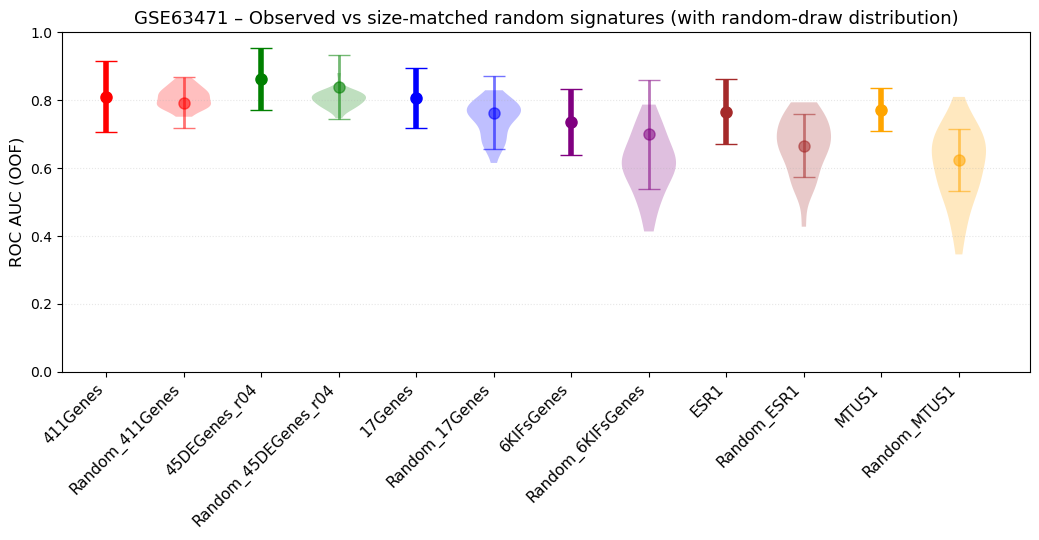

,dataset,probes,mean_test_score,std_test_score,p_delong,param_algorithm__C,auc_oof_global
0,GSE63471,411Genes,0.810823,0.103955,0.953671,0.001265,0.789602
1,GSE63471,Random_411Genes,0.793266,0.075250,NaN,0.003907,0.795413
2,GSE63471,45DEGenes_r04,0.862241,0.090389,0.661537,0.002947,0.869725
3,GSE63471,Random_45DEGenes_r04,0.839514,0.093526,NaN,0.009103,0.824771
4,GSE63471,17Genes,0.805892,0.087959,0.629320,0.028118,0.809786
5,GSE63471,Random_17Genes,0.763829,0.108197,NaN,0.002223,0.740979
6,GSE63471,6KIFsGenes,0.735426,0.096562,0.702897,0.012068,0.727523
7,GSE63471,Random_6KIFsGenes,0.699230,0.159890,NaN,0.000720,0.662385
8,GSE63471,ESR1,0.766679,0.095171,0.599780,0.000543,0.726606
9,GSE63471,Random_ESR1,0.665825,0.093270,NaN,0.049417,0.636697


In [6]:
# === Observed vs Random with B random draws + violin plots  ===

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

# ---------------------------------
# Main parameters
# ---------------------------------
dataset_name = "GSE63471"   # R04
n_splits = 5
n_repeats = 3
B_RANDOM = 30               # number of random draws per signature for the violin
SEED = int(123 % (2**32 - 1))
rng = random.Random(SEED)
C_grid = np.logspace(-4, 2, 50)

# ---------------------------------
# DeLong (unchanged)
# ---------------------------------
def _compute_midrank(x):
    x = np.asarray(x)
    order = np.argsort(x)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(len(x)) + 1
    sorted_x = x[order]
    i = 0
    while i < len(x):
        j = i
        while j < len(x) and sorted_x[j] == sorted_x[i]:
            j += 1
        ranks[order[i:j]] = 0.5 * (i + 1 + j)
        i = j
    return ranks

def _auc_variance_vectors(y_true, y_score):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    pos = y_score[y_true == 1]
    neg = y_score[y_true == 0]
    m, n = len(pos), len(neg)
    if m == 0 or n == 0:
        raise ValueError("DeLong requires both positive and negative samples.")
    all_scores = np.concatenate([pos, neg])
    ranks = _compute_midrank(all_scores)
    r_pos = ranks[:m]
    auc = (r_pos.sum() - m * (m + 1) / 2.0) / (m * n)
    V10 = (r_pos - (m + 1) / 2.0) / n
    r_neg = ranks[m:]
    V01 = ((m + n + 1) / 2.0 - r_neg) / m
    return auc, V10, V01

def delong_2sample_test(y_true, y_score_1, y_score_2):
    auc1, V10_1, V01_1 = _auc_variance_vectors(y_true, y_score_1)
    auc2, V10_2, V01_2 = _auc_variance_vectors(y_true, y_score_2)
    S10 = np.cov(np.vstack([V10_1, V10_2]), bias=False)
    S01 = np.cov(np.vstack([V01_1, V01_2]), bias=False)
    m = np.sum(y_true == 1)
    n = np.sum(y_true == 0)
    var_diff = (S10[0,0] + S10[1,1] - 2*S10[0,1]) / m + (S01[0,0] + S01[1,1] - 2*S01[0,1]) / n
    var_diff = max(var_diff, 1e-12)
    z = (auc1 - auc2) / np.sqrt(var_diff)
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return auc1, auc2, z, p

# ---------------------------------
# OOF with LogisticRegressionCV (built-in inner CV)
# ---------------------------------
def get_oof_preds_with_LRCV(X, y, outer_cv, Cs=C_grid, inner_cv_splits=5, seed=2024):
    """
    - Stratified inner CV (k=inner_cv_splits) via LogisticRegressionCV to select C
    - Fit on the outer training fold, predict probabilities on the outer validation fold
    - Averaged OOF if repeated CV is used (a sample can be validated >1 time)
    Returns: oof, mean_auc (fold-wise mean AUC), std_auc, best_Cs (per fold), auc_oof_global
    """
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    oof_sum = np.zeros_like(y, dtype=float)
    oof_cnt = np.zeros_like(y, dtype=int)
    aucs = []
    best_Cs = []

    for tr_idx, va_idx in outer_cv.split(X, y):
        inner_cv = StratifiedKFold(n_splits=inner_cv_splits, shuffle=True, random_state=seed)
        pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            LogisticRegressionCV(
                Cs=Cs,
                cv=inner_cv,
                scoring="roc_auc",
                solver="liblinear",
                class_weight="balanced",
                max_iter=1000,
                n_jobs=-1,
                refit=True,
                random_state=seed,
            ),
        )
        pipe.fit(X[tr_idx], y[tr_idx])

        proba_va = pipe.predict_proba(X[va_idx])[:, 1]
        oof_sum[va_idx] += proba_va
        oof_cnt[va_idx] += 1
        aucs.append(roc_auc_score(y[va_idx], proba_va))

        lr_cv = pipe.named_steps["logisticregressioncv"]
        best_Cs.append(float(np.ravel(lr_cv.C_)[0]) if hasattr(lr_cv, "C_") else np.nan)

    oof = oof_sum / np.maximum(oof_cnt, 1)
    auc_oof_global = roc_auc_score(y, oof)
    return oof, float(np.mean(aucs)), float(np.std(aucs, ddof=1)), best_Cs, float(auc_oof_global)

# ---------------------------------
# Data loading (objects expected to exist in your environment)
# - MicroArray_DataSet
# - mapping_table
# - liste_gene, name_liste
# ---------------------------------
dataset = MicroArray_DataSet([dataset_name])
dataset.load_data()
y_true = (dataset.metadata['PCR'] == 'PCR').astype(int).values
patient_order = dataset.features.index

# ---------------------------------
# Outer CV (identical for all comparisons)
# ---------------------------------
outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)

# ---------------------------------
# Results + random distributions for violin
# ---------------------------------
dataset_results = pd.DataFrame(columns=[
    'dataset','probes','mean_test_score','std_test_score','p_delong',
    'param_algorithm__C','auc_oof_global'
])
rand_oof_dist = {}   # key = f"Random_{name}", value = list of AUC_OOF (B draws)

# ---------------------------------
# Main loop
# ---------------------------------
for i, genes in enumerate(liste_gene):
    # ----- Observed: intersect with columns present -----
    probes_obs_all = list(set(mapping_table[mapping_table['genes'].isin(genes)]['probes']))
    probes_obs = [p for p in probes_obs_all if p in dataset.features.columns]
    if len(probes_obs) == 0:
        # nothing to test → add NaN rows
        for tag in [name_liste[i], f"Random_{name_liste[i]}"]:
            dataset_results = pd.concat([dataset_results, pd.DataFrame({
                'dataset':[dataset_name], 'probes':[tag],
                'mean_test_score':[np.nan], 'std_test_score':[np.nan],
                'p_delong':[np.nan], 'param_algorithm__C':[np.nan],
                'auc_oof_global':[np.nan]
            })], ignore_index=True)
        continue

    dataset_obs = dataset.get_smaller_subset(restrictions={'patients': None, 'probes': probes_obs})
    X_obs = dataset_obs.features.loc[patient_order].values

    # ----- Random (one draw for baseline + DeLong) -----
    probes_rand = rng.sample(dataset.features.columns.tolist(), len(probes_obs))
    dataset_rand = dataset.get_smaller_subset(restrictions={'patients': None, 'probes': probes_rand})
    X_rand = dataset_rand.features.loc[patient_order].values

    # ----- OOF + LRCV (observed and random baseline) -----
    oof_obs, mean_auc_obs, std_auc_obs, Cs_obs, auc_oof_obs = get_oof_preds_with_LRCV(
        X_obs, y_true, outer_cv, Cs=C_grid, inner_cv_splits=5, seed=SEED
    )
    oof_rand, mean_auc_rand, std_auc_rand, Cs_rand, auc_oof_rand = get_oof_preds_with_LRCV(
        X_rand, y_true, outer_cv, Cs=C_grid, inner_cv_splits=5, seed=SEED
    )

    # ----- DeLong (observed vs this single random baseline) -----
    try:
        _, _, _, p_delong = delong_2sample_test(y_true, oof_obs, oof_rand)
    except Exception:
        p_delong = np.nan

    # ----- B random draws for violin distribution -----
    rand_key = f"Random_{name_liste[i]}"
    rand_oof_dist[rand_key] = []
    for b in range(B_RANDOM):
        probes_rb = rng.sample(dataset.features.columns.tolist(), len(probes_obs))
        dataset_rb = dataset.get_smaller_subset(restrictions={'patients': None, 'probes': probes_rb})
        X_rb = dataset_rb.features.loc[patient_order].values
        oof_rb, _, _, _, auc_oof_rb = get_oof_preds_with_LRCV(
            X_rb, y_true, outer_cv, Cs=C_grid, inner_cv_splits=5, seed=SEED
        )
        rand_oof_dist[rand_key].append(float(auc_oof_rb))

    # ----- Save (observed and the random baseline summary) -----
    dataset_results = pd.concat([dataset_results, pd.DataFrame({
        'dataset':[dataset_name],
        'probes':[name_liste[i]],
        'mean_test_score':[mean_auc_obs],
        'std_test_score':[std_auc_obs],
        'p_delong':[p_delong],
        'param_algorithm__C':[float(np.median(Cs_obs)) if Cs_obs else np.nan],
        'auc_oof_global':[auc_oof_obs]
    })], ignore_index=True)

    dataset_results = pd.concat([dataset_results, pd.DataFrame({
        'dataset':[dataset_name],
        'probes':[rand_key],
        'mean_test_score':[mean_auc_rand],
        'std_test_score':[std_auc_rand],
        'p_delong':[np.nan],
        'param_algorithm__C':[float(np.median(Cs_rand)) if Cs_rand else np.nan],
        'auc_oof_global':[auc_oof_rand]
    })], ignore_index=True)

# ---------------------------------
# Summary figure + violin plots
# ---------------------------------
plt.figure(figsize=(10.5, 5.5))
base_colors = ["red","green","blue","purple","brown","orange","magenta","teal"]
colors = [base_colors[(k//2) % len(base_colors)] for k in range(dataset_results.shape[0])]

# 1) points + error bars (as before)
for k in range(dataset_results.shape[0]):
    m = dataset_results['mean_test_score'].iloc[k]
    e = dataset_results['std_test_score'].iloc[k]
    alpha = 1.0 if (k % 2 == 0) else 0.55  # observed solid, random pale
    elw = 4 if (k % 2 == 0) else 2
    if pd.notnull(m):
        plt.errorbar(k, m, yerr=(0 if pd.isna(e) else e), fmt='o',
                     c=colors[k], alpha=alpha, capsize=8, elinewidth=elw, markersize=8)

# 2) violins at the "Random_*" positions
for i, name in enumerate(name_liste):
    pos_rand = 2*i + 1  # because you add [observed, random] in that order
    key = f"Random_{name}"
    if key in rand_oof_dist and len(rand_oof_dist[key]) > 1:
        vp = plt.violinplot(rand_oof_dist[key], positions=[pos_rand], widths=0.7,
                            showmeans=False, showmedians=False, showextrema=False)
        for body in vp['bodies']:
            body.set_alpha(0.25)
            body.set_facecolor(base_colors[i % len(base_colors)])
            body.set_edgecolor('none')

plt.xticks(range(dataset_results.shape[0]),
           dataset_results['probes'].tolist(),
           rotation=45, ha="right", fontsize=11)
plt.ylabel("ROC AUC (OOF)", fontsize=12)
plt.title(f"{dataset_name} – Observed vs size-matched random signatures (with random-draw distribution)", fontsize=13)
plt.ylim([0, 1.0])
plt.grid(axis='y', linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()

# Results overview
dataset_results
